<a href="https://colab.research.google.com/github/ZinnurovArtur/Colour-Mathcer/blob/main/color_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np 
import cv2
from collections import Counter
from tensorflow.keras.models import load_model


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from skimage.color import rgb2lab,deltaE_cie76

import os
%matplotlib inline


In [ ]:
from google.colab import drive
from keras.datasets import fashion_mnist

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


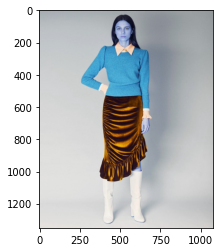

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/datasets/pictures_outfit/bauman/bauman-yeallow.jpg')

plt.imshow(image)

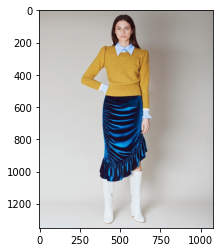

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)



In [ ]:
#Rgb to hext conversion
def rgbTohex(color):
  return "#{:02x}{:02x}{:02x}".format(int(color[0]),int(color[1]), int(color[2]))

In [ ]:
def get_image(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  return image

In [ ]:
def get_colors(image,numCol, chart):
  clf = KMeans(n_clusters= numCol)
  new_image = cv2.resize(image,(600,400),interpolation = cv2.INTER_AREA)
  new_image = new_image.reshape(new_image.shape[0]*new_image.shape[1],3)

  labels = clf.fit_predict(new_image)
  counts = Counter(labels)
  counts = dict(sorted(counts.items()))

  center_colors = clf.cluster_centers_
  ordered_colors = [center_colors[i] for i in counts.keys()]
  hex_colors = [rgbTohex(ordered_colors[i]) for i in counts.keys()]
  rgb_colors = [ordered_colors[i] for i in counts.keys()]
  print(rgb_colors)

  if(chart):
    plt.figure(figsize = (10,10))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
  
  return rgb_colors




[array([152.80789691, 100.14410687,  79.186074  ]),
 array([212.87182196, 210.39576026, 205.21357842]),
 array([174.15922187, 171.15713346, 166.9100437 ]),
 array([41.63915828, 23.86550778, 23.9242452 ]),
 array([234.85266186, 233.58286914, 230.60137583]),
 array([115.27378702,  63.93016173,  49.27609746]),
 array([194.67337218, 191.94044827, 186.69605165]),
 array([153.93392419, 144.01471868, 138.88090528])]

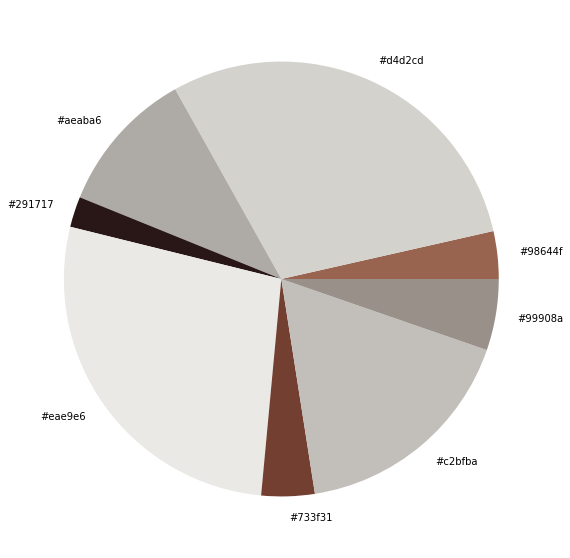

In [ ]:
get_colors(get_image('/content/drive/MyDrive/Colab Notebooks/datasets/pictures_outfit/bauman/baumundpferdgarten_106915056_600072320905456_1611934786290419901_n.jpg'),8,True)

In [ ]:
#Image segmentation 
def get_cloth(filename,stacked=False):
  file1 = cv2.imread(filename)
  file1 = tf.image.resize_with_pad(file1,target_height = 512, target_width = 512)
  rgb = file1.numpy()
  file1 = np.expand_dims(file1,axis=0)/255.
  seq = load_model("/content/drive/MyDrive/Colab Notebooks/datasets/save_ckp_frozen.h5").predict(file1)
  seq = seq[3][0,:,:,0]
  seq = np.expand_dims(seq,axis=-1)
  c1x = rgb*seq
  c2x =rgb*(1-seq)
  cfx = c1x+c2x
  dummcol = np.ones((rgb.shape[0],rgb.shape[1],1))
  rgbx = np.concatenate((rgb,dummcol*255),axis=-1)
  rgbs = np.concatenate((cfx,seq*255),axis =-1)
  if stacked:
    stacked = np.hstack((rgbx,rgbs))
    return stacked
  else:
    return rgbs


In [ ]:
def removeAlpha(im):
  image = cv2.imread(im,cv2.IMREAD_UNCHANGED)
  trans_mask = image[:,:,3] <= 162 # the ml background
  image[trans_mask] = [255,255,255,255]
  new_img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
  return cv2.imwrite("new.png",new_img)

[array([ 48.30113821,  79.24943089, 113.7196748 ]), array([254.99466316, 254.99522733, 254.99594164]), array([ 41.35313496,  69.79798087, 101.3664187 ]), array([19.10433071, 32.73326772, 56.21948819]), array([202.42523364, 207.92056075, 214.55607477]), array([32.63542951, 55.8162762 , 85.08508015]), array([138.25 , 149.83 , 163.795]), array([ 73.42091837, 100.35969388, 128.75892857])]


True

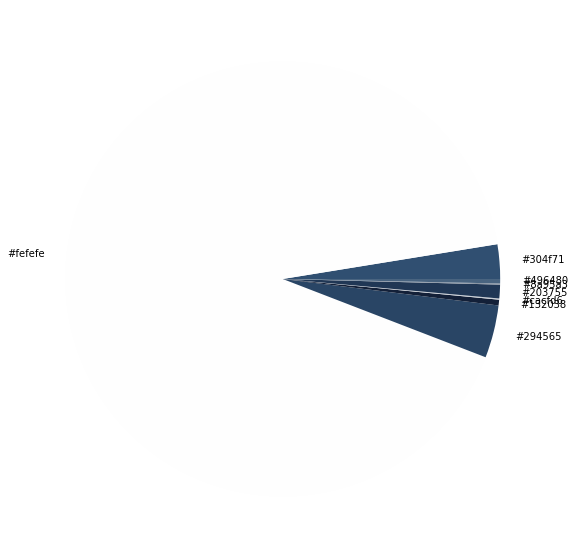

In [ ]:
path_img = "/content/drive/MyDrive/Colab Notebooks/datasets/pictures_outfit/mycommonprojects_2020_9_4_19_35_23.zip (Unzipped Files)/21984967_429610494100932_7920112937287548928_n.jpg"
image = get_cloth(path_img,False)
cv2.imwrite("out.png",image)
removeAlpha("out.png")
get_colors(get_image(('new.png')),8,True)
cv2.imwrite("out.png",image)


[106 151 101]


True

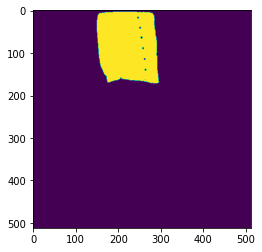

In [ ]:
from PIL import Image 



def converterHUE(b,g,r,sat):
  color = np.uint8([[[b,g,r]]])
  hsv=cv2.cvtColor(color,cv2.COLOR_BGR2HSV)
  hue = hsv[0][0][0]
  print(hsv[0][0])
  low = [hue-sat,hsv[0][0][1]-sat,hsv[0][0][2]-sat]
  up = [hue+sat,255,255]
  return low,up


def changeColor(image,b,g,r,sat):
  im = cv2.imread(image)
  hsv=cv2.cvtColor(im,cv2.COLOR_BGR2HSV)
 
  
  low,up = converterHUE(b, g, r,sat)
  colr_lo = np.array(low)
  colr_hi = np.array(up)
  mask = cv2.inRange(hsv, colr_lo,colr_hi)

  im[mask>0] = (23,255,0)
  cv2.imwrite("result.png",im)
  plt.imshow(mask)


changeColor("new.png",101, 69, 41,80)
img1 = cv2.imread(path_img)
img1 = cv2.resize(img1,(512,512))
img2 = cv2.imread('result.png')
added_image = cv2.addWeighted(img1,0.4,img2,0.4,0)
cv2.imwrite("result2.png",added_image)
